<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-Cost-Function-for-the-Logistic-Model" data-toc-modified-id="A-Cost-Function-for-the-Logistic-Model-1">A Cost Function for the Logistic Model</a></span></li><li><span><a href="#The-Cross-Entropy-Cost" data-toc-modified-id="The-Cross-Entropy-Cost-2">The Cross Entropy Cost</a></span></li><li><span><a href="#Gradient-of-the-Cross-Entropy-Cost" data-toc-modified-id="Gradient-of-the-Cross-Entropy-Cost-3">Gradient of the Cross Entropy Cost</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-4">Summary</a></span></li></ul></div>

In [1]:
# HIDDEN
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import nbinteract as nbi

sns.set()
sns.set_context('talk')
np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.options.display.max_rows = 7
pd.options.display.max_columns = 8
pd.set_option('precision', 2)
# This option stops scientific notation for pandas
# pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
# HIDDEN
def df_interact(df, nrows=7, ncols=7):
    '''
    Outputs sliders that show rows and columns of df
    '''
    def peek(row=0, col=0):
        return df.iloc[row:row + nrows, col:col + ncols]
    if len(df.columns) <= ncols:
        interact(peek, row=(0, len(df) - nrows, nrows), col=fixed(0))
    else:
        interact(peek,
                 row=(0, len(df) - nrows, nrows),
                 col=(0, len(df.columns) - ncols))
    print('({} rows, {} columns) total'.format(df.shape[0], df.shape[1]))

In [3]:
# HIDDEN
lebron = pd.read_csv('lebron.csv')

## A Loss Function for the Logistic Model

We have defined a regression model for probabilities, the logistic model:

$$
\begin{aligned}
f_\hat{\boldsymbol{\theta}} (\boldsymbol{x}) = \sigma(\hat{\boldsymbol{\theta}} \cdot \boldsymbol{x})
\end{aligned}
$$

Like the model for linear regression, this model has parameters $ \hat{\boldsymbol{\theta}} $, a vector that contains one parameter for each feature of $ \boldsymbol{x} $. We now address the problem of defining a loss function for this model that allows us to fit the model's parameters to data.

Intuitively, we want the model's predictions to match the data as closely as possible. Below we recreate a plot of LeBron's shot attempts in the 2017 NBA Playoffs using the distance of each shot from the basket. The points are jittered on the y-axis to mitigate overplotting.

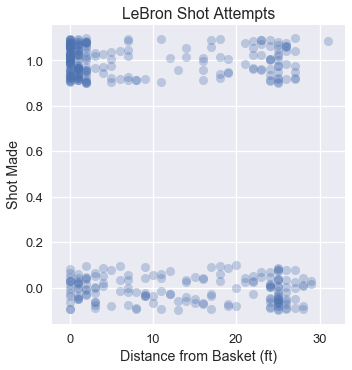

In [4]:
# HIDDEN
np.random.seed(42)
sns.lmplot(x='shot_distance', y='shot_made',
           data=lebron,
           fit_reg=False, ci=False,
           y_jitter=0.1,
           scatter_kws={'alpha': 0.3})
plt.title('LeBron Shot Attempts')
plt.xlabel('Distance from Basket (ft)')
plt.ylabel('Shot Made');

Noticing the large cluster of made shots close to the basket and the smaller cluster of missed shots further from the basket, we expect that a logistic model fitted on this data might look like:

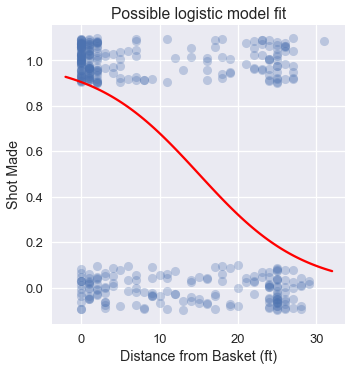

In [5]:
# HIDDEN
from scipy.special import expit

np.random.seed(42)
sns.lmplot(x='shot_distance', y='shot_made',
           data=lebron,
           fit_reg=False, ci=False,
           y_jitter=0.1,
           scatter_kws={'alpha': 0.3})

xs = np.linspace(-2, 32, 100)
ys = expit(-0.15 * (xs - 15))
plt.plot(xs, ys, c='r', label='Logistic model')

plt.title('Possible logistic model fit')
plt.xlabel('Distance from Basket (ft)')
plt.ylabel('Shot Made');

Although we can use the mean squared error loss function as we have for linear regression, it is non-convex for a logistic model and thus difficult to optimize.

## Cross-Entropy Loss

Instead of the mean squared error, we use the **cross-entropy loss**. Let $ \boldsymbol{X} $ represent the $ n \times p $ input data matrix, $ \boldsymbol{y} $ the vector of observed data values, and $ f_\boldsymbol{\theta}(\boldsymbol{x}) $ the logistic model. $\boldsymbol{\theta}$ contains the current parameter values. Using this notation, the average cross-entropy loss is defined as:

$$
\begin{aligned}
L(\boldsymbol{\theta}, \boldsymbol{X}, \boldsymbol{y}) = \frac{1}{n} \sum_i \left(- y_i \ln (f_\boldsymbol{\theta}(\boldsymbol{X}_i)) - (1 - y_i) \ln (1 - f_\boldsymbol{\theta}(\boldsymbol{X}_i) \right)
\end{aligned}
$$

You may observe that as usual we take the mean loss over each point in our dataset. The inner expression in the above summation represents the loss at one data point $(\boldsymbol{X}_i, y_i)$: 

$$
\begin{aligned}
\ell(\boldsymbol{\theta}, \boldsymbol{X}_i, y_i) = - y_i \ln (f_\boldsymbol{\theta}(\boldsymbol{X}_i)) - (1 - y_i) \ln (1 - f_\boldsymbol{\theta}(\boldsymbol{X}_i) )
\end{aligned}
$$

Recall that each $ y_i $ is either 0 or 1 in our dataset. If $ y_i = 0 $, the first term in the loss is zero. If $ y_i = 1 $, the second term in the loss is zero. Thus, for each point in our dataset, only one term of the cross-entropy loss contributes to the overall loss.

Suppose $ y_i = 0 $ and our predicted probability $ f_\boldsymbol{\theta}(\boldsymbol{X}_i) = 0 $—our model is completely correct. The loss for this point will be:

$$
\begin{aligned}
\ell(\boldsymbol{\theta}, \boldsymbol{X}_i, y_i)
&= - y_i \ln (f_\boldsymbol{\theta}(\boldsymbol{X}_i)) - (1 - y_i) \ln (1 - f_\boldsymbol{\theta}(\boldsymbol{X}_i) ) \\
&= - 0 - (1 - 0) \ln (1 - 0 ) \\
&= - \ln (1) \\
&= 0
\end{aligned}
$$

As expected, the loss for a correct prediction is $ 0 $. You may verify that the further the predicted probability is from the true value, the greater the loss.

Minimizing the overall cross-entropy loss requires the model $ f_\boldsymbol{\theta}(\boldsymbol{x}) $ to make the most accurate predictions it can. Conveniently, this loss function is convex, making gradient descent a useful choice for optimization.

## Gradient of the Cross-Entropy Loss

In order to run gradient descent on a model's cross-entropy loss we must calculate the gradient of the loss function. First, we compute the derivative of the sigmoid function since we'll use it in our gradient calculation.

$$
\begin{aligned}
\sigma(t) &= \frac{1}{1 + e^{-t}} \\
\sigma'(t) &= \frac{e^{-t}}{(1 + e^{-t})^2} \\
\sigma'(t) &= \frac{1}{1 + e^{-t}} \cdot \left(1 - \frac{1}{1 + e^{-t}} \right) \\
\sigma'(t) &= \sigma(t) (1 - \sigma(t))
\end{aligned}
$$

The derivative of the sigmoid function can be conveniently expressed in terms of the sigmoid function itself.

As a shorthand, we define $ \sigma_i = f_\boldsymbol{\theta}(\boldsymbol{X}_i) = \sigma(\boldsymbol{X}_i \cdot \boldsymbol{\theta}) $. We will soon need the gradient of $ \sigma_i $ with respect to the vector $ \boldsymbol{\theta} $ so we will derive it now using a straightforward application of the chain rule. 

$$
\begin{aligned}
\nabla_{\boldsymbol{\theta}} \sigma_i
&= \nabla_{\boldsymbol{\theta}} \sigma(\boldsymbol{X}_i \cdot \boldsymbol{\theta}) \\
&= \sigma(\boldsymbol{X}_i \cdot \boldsymbol{\theta}) (1 - \sigma(\boldsymbol{X}_i \cdot \boldsymbol{\theta}))  \nabla_{\boldsymbol{\theta}} (\boldsymbol{X}_i \cdot \boldsymbol{\theta}) \\
&= \sigma_i (1 - \sigma_i) \boldsymbol{X}_i 
\end{aligned}
$$

Now, we derive the gradient of the cross-entropy loss with respect to the model parameters $ \boldsymbol{\theta} $. In the derivation below, we let $ \sigma_i = f_\boldsymbol{\theta}(\boldsymbol{X}_i) = \sigma(\boldsymbol{X}_i \cdot \boldsymbol{\theta}) $.

$$
\begin{aligned}
L(\boldsymbol{\theta}, \boldsymbol{X}, \boldsymbol{y})
&= \frac{1}{n} \sum_i \left(- y_i \ln (f_\boldsymbol{\theta}(\boldsymbol{X}_i)) - (1 - y_i) \ln (1 - f_\boldsymbol{\theta}(\boldsymbol{X}_i) \right) \\
&= \frac{1}{n} \sum_i \left(- y_i \ln \sigma_i - (1 - y_i) \ln (1 - \sigma_i ) \right) \\
\nabla_{\boldsymbol{\theta}} L(\boldsymbol{\theta}, \boldsymbol{X}, \boldsymbol{y})
&= \frac{1}{n} \sum_i \left(
    - \frac{y_i}{\sigma_i} \nabla_{\boldsymbol{\theta}} \sigma_i
    + \frac{1 - y_i}{1 - \sigma_i} \nabla_{\boldsymbol{\theta}} \sigma_i
\right) \\
&= - \frac{1}{n} \sum_i \left(
    \frac{y_i}{\sigma_i} - \frac{1 - y_i}{1 - \sigma_i}
\right) \nabla_{\boldsymbol{\theta}} \sigma_i \\
&= - \frac{1}{n} \sum_i \left(
    \frac{y_i}{\sigma_i} - \frac{1 - y_i}{1 - \sigma_i}
\right) \sigma_i (1 - \sigma_i) \boldsymbol{X}_i \\
&= - \frac{1}{n} \sum_i \left(
    y_i - \sigma_i
\right) \boldsymbol{X}_i \\
\end{aligned}
$$

The surprisingly simple gradient expression allows us to fit a logistic model to the cross-entropy loss using gradient descent. Section 17.6 delves into deriving update formulas for batch, stochastic, and mini-batch gradient descent.

## Summary

Since the cross-entropy loss function is convex, we minimize it using gradient descent to fit logistic models to data. We now have the necessary components of logistic regression: the model, loss function, and minimization procedure. In Section 17.5, we take a closer look at why we use average cross-entropy loss for logistic regression.